<a href="https://colab.research.google.com/github/Shrey-Viradiya/PyTorch_for_DL/blob/master/PyTorch_Debugging_PyTorch_Models__Class_Activation_Mappings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch_Debugging_PyTorch_Models_Class_Activation_Mappings

Refer https://github.com/falloutdurham/Beginners-pytorch-deep-learning/blob/master/chapter7/cam.ipynb

In [1]:
!wget https://raw.githubusercontent.com/falloutdurham/beginners-pytorch-deep-learning/master/chapter7/casper2.jpg

--2020-10-04 10:56:41--  https://raw.githubusercontent.com/falloutdurham/beginners-pytorch-deep-learning/master/chapter7/casper2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212303 (207K) [image/jpeg]
Saving to: ‘casper2.jpg’

casper2.jpg         100%[===================>] 207.33K  --.-KB/s    in 0.03s   

2020-10-04 10:56:41 (5.93 MB/s) - ‘casper2.jpg’ saved [212303/212303]



In [2]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

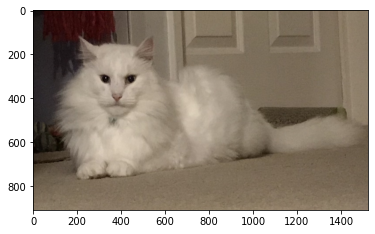

In [3]:
image = Image.open("./casper2.jpg")
imshow(image)

In [4]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [5]:
tensor = preprocess(image)

In [6]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

Having converted our image into a PyTorch variable, we need a model to generate a prediction. Let's use ResNet18, put it in evaluation mode, and stick it on the GPU using the CUDA libraries.

In [7]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [8]:
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [10]:
final_layer = model._modules.get('layer4')

In [11]:
activated_features = SaveFeatures(final_layer)

In [12]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [13]:
activated_features.remove()

Using topk(), we can see that our model is 78% confident that this picture is class 283. Looking that up in the ImageNet classes, that gives us…'persian cat'. Which I would say is not a terrible guess!

In [14]:
topk(pred_probabilities,1)

torch.return_types.topk(values=tensor([0.7832], device='cuda:0'), indices=tensor([283], device='cuda:0'))

Having made the guess, let's see where the neural network was focussing its attention. The getCAM() method here takes the activated features of the convnet, the weights of the fully-connected layer (on the side of the average pooling), and the class index we want to investigate (283 in our case). We index into the fully-connected layer to get the weights for that class and calculate the dot product with our features from the image.

In [15]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [16]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [17]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -1

In [18]:
class_idx = topk(pred_probabilities,1)[1].int()

In [19]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

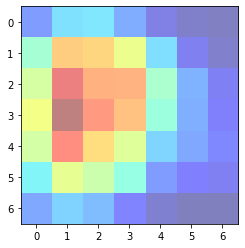

In [20]:
imshow(overlay[0], alpha=0.5, cmap='jet')

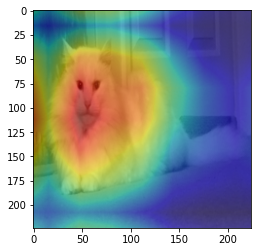

In [21]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

But wait, there's a bit more - we can also look at the model's second choice for Casper.

In [22]:
class_idx = topk(pred_probabilities,2)[1].int()

In [23]:
class_idx

tensor([283, 332], device='cuda:0', dtype=torch.int32)

In [24]:
overlay = getCAM(activated_features.features, weight_softmax, 332 )

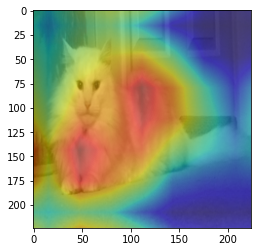

In [25]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');


Although the heatmap is similar, the network is focussing a touch more on his fluffy coat to suggest he might be class 332 - an Angora rabbit. And well, he is a Turkish Angora cat after all…